In [1]:
import os
import numpy as np
import torch
import torch.optim as optim
import torch.distributions as D
from tqdm import tqdm, trange
from src.svgd import SVGD
from src.gsvgd import FullGSVGDBatch
from src.kernel import RBF, BatchRBF
from src.utils import plot_particles
from src.Tmy_svgd import tmySVGD
from src.manifold import Grassmann
from src.s_svgd import SlicedSVGD
from src.mysvgd import mySVGD
import matplotlib.pyplot as plt
from src.rand_mysvgd import min_mySVGD

import pickle
import argparse
import time

import torch.autograd as autograd


/home/zhoujk/anaconda3/envs/AG/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def mix_gauss_experiment(mixture_dist, means):
    '''Mixture of Multivariate gaussian with cov matrices being the identity.
    Args:
        probs: Tensor of shape (nmix,) for the mixture_distribution.
        means: Tensor of shape (nmix, d), where nmix is the number of components 
            and d is the dimension of each component.
    '''
    nmix = means.shape[0]
    comp = D.Independent(D.Normal(means.to(device), torch.ones((nmix, means.shape[1]), device=device)), 1)
    distribution = D.mixture_same_family.MixtureSameFamily(mixture_dist, comp) 
    return distribution


def points_on_circle(theta, rad):
    '''Generate d-dim points whose first two dimensions lies on a circle of 
    radius rad, with position being specified by the angle from the positive 
    x-axis theta.
    '''
    return torch.Tensor([[rad * np.cos(theta + 0.25*np.pi), rad * np.sin(theta + 0.25*np.pi)]])

In [3]:
parser = argparse.ArgumentParser(description='Running xshaped experiment.')
parser.add_argument('--dim', type=int,default=10, help='dimension')
parser.add_argument('--effdim', type=int, default=-1, help='dimension')
parser.add_argument('--lr', type=float,default=0.01, help='learning rate')
parser.add_argument('--lr_g', type=float, default=0.1, help='learning rate for g')
parser.add_argument('--delta', type=float,default=0.01, help='stepsize for projections')
parser.add_argument('--T', type=float, default=1e-4, help='noise multiplier for projections')
parser.add_argument('--nparticles', type=int,default=100, help='no. of particles')
parser.add_argument('--epochs', type=int, default=20000,help='no. of epochs')
parser.add_argument('--nmix', type=int, default=4, help='no. of modes')
parser.add_argument('--metric', type=str, default="energy", help='distance metric')
parser.add_argument('--noise', type=str, default="True", help='whether to add noise')
parser.add_argument('--kernel', type=str, default="rbf", help='kernel')
parser.add_argument('--gpu', type=int, default=5, help='gpu')
parser.add_argument('--seed', type=int, default=0, help='random seed') 
parser.add_argument('--suffix', type=str, default="", help='suffix for res folder')
parser.add_argument('--m', type=int, help='no. of projections')
parser.add_argument('--save_every', type=int, default=200, help='step intervals to save particles')
parser.add_argument('--method', type=str, default="all", help='which method to use')



_StoreAction(option_strings=['--method'], dest='method', nargs=None, const=None, default='all', type=<class 'str'>, choices=None, required=False, help='which method to use', metavar=None)

In [4]:
args = parser.parse_args([])
device = torch.device(f'cuda:{args.gpu}' if args.gpu != -1 else 'cpu')
dim = args.dim
lr = args.lr
delta = args.delta
T = args.T
nparticles = args.nparticles
epochs = args.epochs
seed = args.seed
eff_dims = [args.effdim] if args.effdim > 0 else [1, 2, 5]
nmix = args.nmix
add_noise = True if args.noise == "True" else False
radius = 5
save_every = args.save_every
print(f"Running for dim: {dim}, lr: {lr}, nparticles: {nparticles}")

Running for dim: 10, lr: 0.01, nparticles: 100


In [5]:
def comm_func_eval(samples, ground_truth):

    samples = samples.clone()
    ground_truth = ground_truth.clone()

    def ex():
        f0 = torch.mean(samples, axis=0)
        f1 = torch.mean(ground_truth, axis=0)
        return torch.mean((f0-f1)**2)

    def exsqr():
        f0 = torch.var(samples, axis=0)
        f1 = torch.var(ground_truth, axis=0)
        return torch.mean((f0-f1)**2)


    out = {}
    out['mean_dis'] = ex()
    out['var_dis'] = exsqr()
    return out

In [6]:

device = torch.device(f'cuda:{args.gpu}' if args.gpu != -1 else 'cpu')

metric = args.metric

results_folder = f"./res/multimodal{args.suffix}/{args.kernel}_epoch{epochs}_lr{lr}_delta{delta}_n{nparticles}_dim{dim}"
results_folder = f"{results_folder}/seed{seed}"

In [7]:

if not os.path.exists(results_folder):
    os.makedirs(results_folder)

if args.kernel == "rbf":
    Kernel = RBF
    BatchKernel = BatchRBF

In [8]:
print(f"Device: {device}")
torch.manual_seed(seed)
list_norm = []
list_gr_var = []
list_tr = []
list_eig = []

for dim in range(50, 100, 10):
    ## target density
    mix_means = torch.cat(
        [points_on_circle(i * 2*np.pi / nmix, rad=radius) for i in range(nmix)]).to(device)
    mix_means = torch.cat((mix_means, torch.zeros((mix_means.shape[0], dim - 2), device=device)), dim=1)

    distribution = mix_gauss_experiment(
        mixture_dist=D.Categorical(torch.ones(mix_means.shape[0], device=device)),
        means=mix_means
    )


    # sample from target (for computing metric)
    x_target = distribution.sample((nparticles, )).to(device)
    cov = torch.cov(x_target)

    # sample from variational density
    x_init =  torch.randn(nparticles, *distribution.event_shape).to(device)

    ## SVGD
    cov = torch.cov(x_target.T)

    if args.method in ["SVGD", "all"]:
        

        print("Running SVGD")
        # sample from variational density
        x = x_init.clone().to(device)
        kernel = Kernel(method="med_heuristic")
        svgd = SVGD(distribution, kernel, optim.Adam([x], lr=lr), device=device)
        
        svgd.fit(x, epochs, verbose=True, save_every=save_every)
        

    theta = x
        
    


    cov_svgd = torch.cov(theta.T)
    print(torch.linalg.norm(cov - cov_svgd))
    list_norm.append(torch.linalg.norm(cov - cov_svgd))
    print(comm_func_eval(theta, x_target)['var_dis'])
    list_gr_var.append(comm_func_eval(theta, x_target)['var_dis'])
    print(torch.trace(cov - cov_svgd))
    list_tr.append(torch.trace(cov - cov_svgd))
    (evals, evecs) = torch.linalg.eig(cov - cov_svgd)
    print(evals[0])
    list_eig.append(evals[0])

Device: cuda:5
Running SVGD


100%|██████████| 20000/20000 [00:57<00:00, 349.88it/s]


tensor(8.5717, device='cuda:5')
tensor(0.5712, device='cuda:5')
tensor(36.8840, device='cuda:5')
tensor(-2.1016+0.j, device='cuda:5')
Running SVGD


100%|██████████| 20000/20000 [01:07<00:00, 295.19it/s]


tensor(10.3745, device='cuda:5')
tensor(0.6456, device='cuda:5')
tensor(46.4078, device='cuda:5')
tensor(4.4751+0.j, device='cuda:5')
Running SVGD


100%|██████████| 20000/20000 [01:22<00:00, 241.01it/s]


tensor(11.6091, device='cuda:5')
tensor(0.7103, device='cuda:5')
tensor(57.1222, device='cuda:5')
tensor(4.6247+0.j, device='cuda:5')
Running SVGD


100%|██████████| 20000/20000 [01:06<00:00, 300.16it/s]


tensor(13.2710, device='cuda:5')
tensor(0.7074, device='cuda:5')
tensor(65.7565, device='cuda:5')
tensor(5.7363+0.j, device='cuda:5')
Running SVGD


100%|██████████| 20000/20000 [01:00<00:00, 332.45it/s]

tensor(14.3805, device='cuda:5')
tensor(0.7638, device='cuda:5')
tensor(77.5002, device='cuda:5')
tensor(6.5262+0.j, device='cuda:5')


/home/zhoujk/anaconda3/envs/AG/lib/python3.9/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /opt/conda/conda-bld/pytorch_1666643016022/work/aten/src/ATen/native/TensorShape.cpp:3190.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


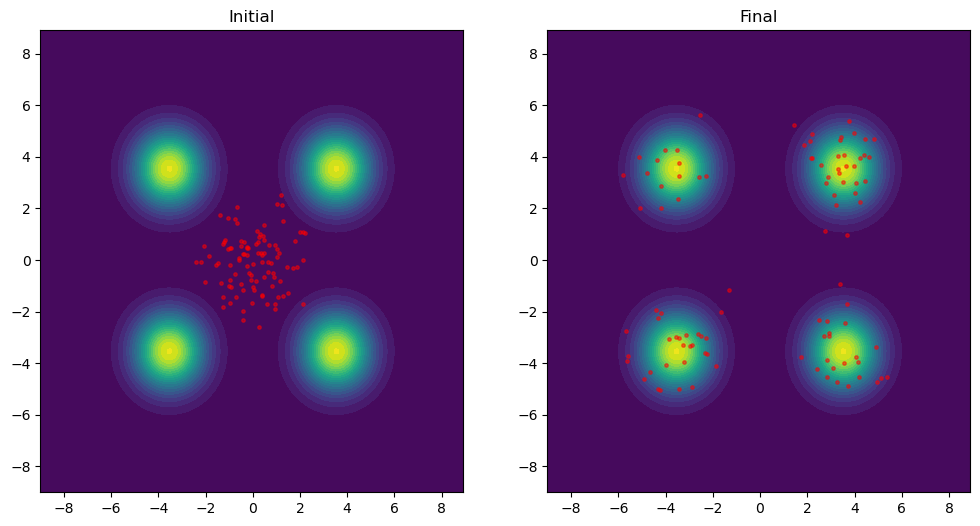

In [9]:
fig_svgd = plot_particles(
    x_init.detach(), 
    x_target.detach(), 
    distribution, 
    d=9.0, 
    step=0.1, 
    concat=mix_means[0, 2:],
    savedir=results_folder + f"/svgd.png"
)

torch.Size([90, 90])
tensor(14.3805, device='cuda:5')
{'mean_dis': tensor(0.0119, device='cuda:5'), 'var_dis': tensor(0.7638, device='cuda:5')}
tensor(77.5002, device='cuda:5')
tensor(6.5262+0.j, device='cuda:5')


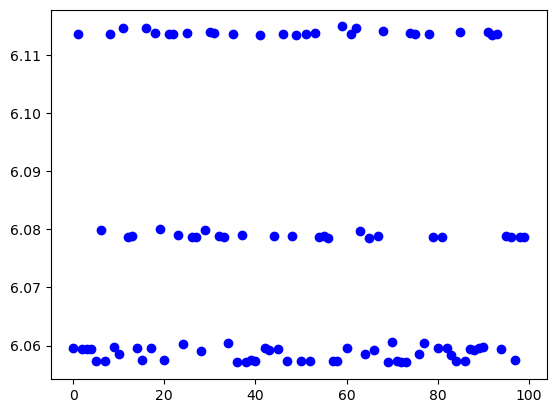

In [10]:
theta = x
cov = torch.cov(x_target.T)
index_svgd = []
samn_svgd = []
for i in range(theta.shape[0]):
    samn_svgd.append(torch.linalg.norm(theta[i,:].cpu()).item())
    index_svgd.append(i)

import matplotlib.pyplot as plt
plt.scatter(index_svgd, samn_svgd, c='blue')

cov_svgd = torch.cov(theta.T)
print(cov_svgd.shape)

print(torch.linalg.norm(cov - cov_svgd))
print(comm_func_eval(theta, x_target))
print(torch.trace(cov - cov_svgd))
(evals, evecs) = torch.linalg.eig(cov - cov_svgd)
print(evals[0])


In [11]:
print("Running min_mySVGD")

def score(X):
        X_cp = X.clone().detach().requires_grad_()
        log_prob = distribution.log_prob(X_cp)
        score_func = autograd.grad(log_prob.sum(), X_cp)[0]
        return score_func

list_norm_mysvgd = []
list_gr_var_mysvgd = []
list_tr_mysvgd= []
list_eig_mysvgd = []

# sample from variational density
for dim in range(50, 100, 10):
    ## target density
    mix_means = torch.cat(
        [points_on_circle(i * 2*np.pi / nmix, rad=radius) for i in range(nmix)]).to(device)
    mix_means = torch.cat((mix_means, torch.zeros((mix_means.shape[0], dim - 2), device=device)), dim=1)

    distribution = mix_gauss_experiment(
        mixture_dist=D.Categorical(torch.ones(mix_means.shape[0], device=device)),
        means=mix_means
    )


    # sample from target (for computing metric)
    x_target = distribution.sample((nparticles, )).to(device)
    cov = torch.cov(x_target)

    # sample from variational density
    x_init =  torch.randn(nparticles, *distribution.event_shape).to(device)

    ## SVGD
    cov = torch.cov(x_target.T)

    
    x0 = x_init
    vector1  = torch.randn(nparticles, dim).to(device)

   
        
    theta, vector = tmySVGD(kernel,device).update(x0, score,  k = 2, n_iter = 20000,  debug = False, lr= lr, vector=vector1)
        #mean = np.mean(theta, axis=0)  + np.random.random(1)
        #var_theta = np.cov(theta.T) + np.random.random(1)
        #x0 = np.random.multivariate_normal(mean, var_theta,num)
        
        

    cov_mysvgd = torch.cov(theta.T)
    print(torch.linalg.norm(cov - cov_mysvgd))
    list_norm_mysvgd.append(torch.linalg.norm(cov - cov_mysvgd))
    print(comm_func_eval(theta, x_target)['var_dis'])
    list_gr_var_mysvgd.append(comm_func_eval(theta, x_target)['var_dis'])
    print(torch.trace(cov - cov_mysvgd))
    list_tr_mysvgd.append(torch.trace(cov - cov_mysvgd))
    (evals, evecs) = torch.linalg.eig(cov - cov_mysvgd)
    print(evals[0])
    list_eig_mysvgd.append(evals[0])
    

Running min_mySVGD


100%|██████████| 20000/20000 [1:18:04<00:00,  4.27it/s]


Filename: /home/zhoujk/SVGD/SVGD_code/GSVGD-main/src/Tmy_svgd.py

Line #    Mem usage    Increment  Occurences   Line Contents
    65   1709.2 MiB   1709.2 MiB           1       @profile
    66                                             def update(self, x0, lnprob, n_iter = 1000, k = 8, debug = False,lr=0.001, vector = 0):
    67                                         
    68   1709.3 MiB      0.0 MiB           1           theta = x0.clone()
    69   1709.3 MiB      0.0 MiB           1           x = x0.clone()
    70                                         
    71                                                 
    72                                         
    73                                         
    74  43962.3 MiB   -669.0 MiB       20001           for s in trange(n_iter):
    75                                                     
    76                                                     
    77                                                     
    78  43960.0 MiB   

 73%|███████▎  | 14698/20000 [1:09:41<25:08,  3.51it/s]


OutOfMemoryError: CUDA out of memory. Tried to allocate 2.00 MiB (GPU 5; 23.69 GiB total capacity; 22.99 GiB already allocated; 2.94 MiB free; 22.99 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [ ]:
## GSVGD

list_norm_gsvgd = []
list_gr_var_gsvgd = []
list_tr_gsvgd= []
list_eig_gsvgd = []

# sample from variational density
for dim in range(50, 100, 10):
    ## target density
    mix_means = torch.cat(
        [points_on_circle(i * 2*np.pi / nmix, rad=radius) for i in range(nmix)]).to(device)
    mix_means = torch.cat((mix_means, torch.zeros((mix_means.shape[0], dim - 2), device=device)), dim=1)

    distribution = mix_gauss_experiment(
        mixture_dist=D.Categorical(torch.ones(mix_means.shape[0], device=device)),
        means=mix_means
    )


    # sample from target (for computing metric)
    x_target = distribution.sample((nparticles, )).to(device)
    cov = torch.cov(x_target)

    # sample from variational density
    x_init =  torch.randn(nparticles, *distribution.event_shape).to(device)

    ## SVGD
    cov = torch.cov(x_target.T)
    if args.method in ["GSVGD", "all"]:
        res_gsvgd = [0] * len(eff_dims)
        def run_gsvgd(eff_dims):
            for i, eff_dim in enumerate(eff_dims):
                print(f"Running GSVGD with eff dim = {eff_dim}")

                m = min(20, dim // eff_dim) if args.m is None else args.m
                print("number of projections:", m)

                # sample from variational density
                x_init_gsvgd = x_init.clone()
                x_gsvgd = x_init_gsvgd.clone()

                kernel_gsvgd = BatchKernel(method="med_heuristic")
                optimizer = optim.Adam([x_gsvgd], lr=lr)
                manifold = Grassmann(dim, eff_dim)
                U = torch.eye(dim, device=device).requires_grad_(True)
                U = U[:, :(m*eff_dim)]

                gsvgd = FullGSVGDBatch(
                    target=distribution,
                    kernel=kernel_gsvgd,
                    manifold=manifold,
                    optimizer=optimizer,
                    delta=delta,
                    T=T,
                    device=device,
                    noise=add_noise
                )
                start = time.time()
                U, metric_gsvgd = gsvgd.fit(x_gsvgd, U, m, epochs, 
                    verbose=True, save_every=save_every, threshold=0.0001*m)
                elapsed_time = time.time() - start

                # plot particles
                fig_gsvgd = plot_particles(
                    x_init_gsvgd.detach(), 
                    x_gsvgd.detach(), 
                    distribution, 
                    d=9.0, 
                    step=0.1, 
                    concat=mix_means[0, 2:].to(device),
                    savedir=results_folder + f"/fullgsvgd_effdim{eff_dim}_lr{lr}_delta{delta}_m{m}_T{T}.png"
                )

                # store results
                res_gsvgd[i] = {
                    "init":x_init_gsvgd, "final":x_gsvgd, "metric":metric_gsvgd, 
                    "fig":fig_gsvgd, "particles":gsvgd.particles, "pam":gsvgd.pam, "res": gsvgd,
                    "elapsed_time": elapsed_time}
            return res_gsvgd,x_gsvgd

    res_gsvgd ,x_gsvgd= run_gsvgd(eff_dims)
    theta = x_gsvgd
    cov_gsvgd = torch.cov(theta.T)
    print(torch.linalg.norm(cov - cov_gsvgd))
    list_norm_gsvgd.append(torch.linalg.norm(cov - cov_gsvgd))
    print(comm_func_eval(theta, x_target)['var_dis'])
    list_gr_var_gsvgd.append(comm_func_eval(theta, x_target)['var_dis'])
    print(torch.trace(cov - cov_gsvgd))
    list_tr_gsvgd.append(torch.trace(cov - cov_gsvgd))
    (evals, evecs) = torch.linalg.eig(cov - cov_gsvgd)
    print(evals[0])
    list_eig_gsvgd.append(evals[0])
    


In [ ]:
theta = x_gsvgd
cov = torch.cov(x_target.T)
index_svgd = []
samn_svgd = []
for i in range(theta.shape[0]):
    samn_svgd.append(torch.linalg.norm(theta[i,:].cpu()).item())
    index_svgd.append(i)

import matplotlib.pyplot as plt
plt.scatter(index_svgd, samn_svgd, c='blue')

cov_gsvgd = torch.cov(theta.T)


print(torch.linalg.norm(cov - cov_gsvgd))
print(comm_func_eval(theta, x_target))
print(torch.trace(cov - cov_gsvgd))
(evals, evecs) = torch.linalg.eig(cov - cov_gsvgd)
print(evals[0])

In [ ]:
## S-SVGD
list_norm_ssvgd = []
list_gr_var_ssvgd = []
list_tr_ssvgd = []
list_eig_ssvgd = []

for dim in range(50, 100, 10):
    ## target density
    mix_means = torch.cat(
        [points_on_circle(i * 2*np.pi / nmix, rad=radius) for i in range(nmix)]).to(device)
    mix_means = torch.cat((mix_means, torch.zeros((mix_means.shape[0], dim - 2), device=device)), dim=1)

    distribution = mix_gauss_experiment(
        mixture_dist=D.Categorical(torch.ones(mix_means.shape[0], device=device)),
        means=mix_means
    )


    # sample from target (for computing metric)
    x_target = distribution.sample((nparticles, )).to(device)
    cov = torch.cov(x_target)

    # sample from variational density
    x_init =  torch.randn(nparticles, *distribution.event_shape).to(device)

    
    cov = torch.cov(x_target.T)
    if args.method in ["S-SVGD", "all"]:
        # sample from variational density
        print("Running S-SVGD")
        x_init_s_svgd = x_init.clone()
        x_s_svgd = x_init_s_svgd.clone().requires_grad_()
        s_svgd = SlicedSVGD(distribution, device=device)

        start = time.time()
        x_s_svgd, metric_s_svgd = s_svgd.fit(
            samples=x_s_svgd, 
            n_epoch=epochs, 
            lr=args.lr_g,
            eps=lr,
            save_every=save_every
        )
    
    theta = x_s_svgd
    cov_ssvgd = torch.cov(theta.T)
    print(torch.linalg.norm(cov - cov_ssvgd))
    list_norm_ssvgd.append(torch.linalg.norm(cov - cov_ssvgd))
    print(comm_func_eval(theta, x_target)['var_dis'])
    list_gr_var_ssvgd.append(comm_func_eval(theta, x_target)['var_dis'])
    print(torch.trace(cov - cov_gsvgd))
    list_tr_ssvgd.append(torch.trace(cov - cov_ssvgd))
    (evals, evecs) = torch.linalg.eig(cov - cov_ssvgd)
    print(evals[0])
    list_eig_ssvgd.append(evals[0])
    
    
    

 

In [ ]:
 comm_func_eval(x_s_svgd , x_target)['var_dis']


In [ ]:
theta = x_s_svgd 
cov = torch.cov(x_target.T)
index_svgd = []
samn_svgd = []
for i in range(theta.shape[0]):
    samn_svgd.append(torch.linalg.norm(theta[i,:].cpu()).item())
    index_svgd.append(i)

import matplotlib.pyplot as plt
plt.scatter(index_svgd, samn_svgd, c='blue')

cov_ssvgd = torch.cov(theta.T)


print(torch.linalg.norm(cov - cov_ssvgd))
print(comm_func_eval(theta, x_target))
print(torch.trace(cov - cov_ssvgd))
(evals, evecs) = torch.linalg.eig(cov - cov_ssvgd)
print(evals[0])